# Learning PyTorch with Examples

In this notebook we explore some of the main functionality of PyTorch, and demystifying the black-box surrounding them.

We will use a problem of fitting $y=sin(x)$ with a third order polynomial as our running example. The network will have four parameters, and will be trained with gradient descent to fit random data by minimizing the Euclidean distance between the network output and the true output.

*Following the official tutorial: https://pytorch.org/tutorials/beginner/pytorch_with_examples.html*

## Installation

Imports:

In [1]:
import numpy as np
import math
import torch
import random
import matplotlib.pyplot as plt
%matplotlib inline
import time

## Tensors

### Numpy

Before introducing PyTorch, we will first implement the network using numpy. We will manually implement the forward and backward passes through the network using numpy operations.

The following is our raw data:

In [2]:
# create random input and output data
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)

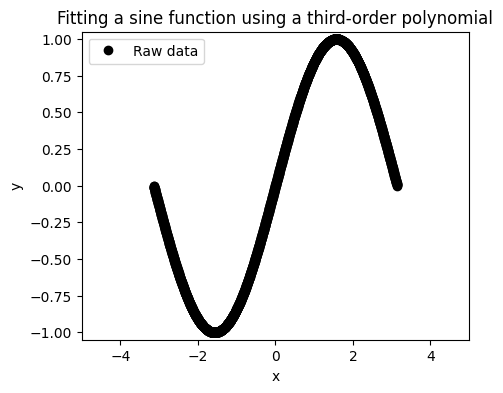

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.plot(x, y, color='k', marker='o', ls=' ', label='Raw data')

ax.set_xlim(-5, 5)
ax.set_ylim(-1.05, 1.05)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Fitting a sine function using a third-order polynomial')

ax.legend()
plt.show()

We will create a function to act as our third-order polynomal, where the four parameters $a$, $b$, $c$ and $d$ act as our weights:

In [4]:
# create function
func = lambda a, b, c, d, x: a + b * x + c * x**2 + d * x**3

# randomly initialize weights
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

y_pred_initial = func(a, b, c, d, x)

print(f'Initial function: y = {a} + {b} x + {c} x^2 + {d} x^3')

Initial function: y = -0.3299966478492582 + -0.09042775990139386 x + -1.7559043289286844 x^2 + -0.346699310151739 x^3


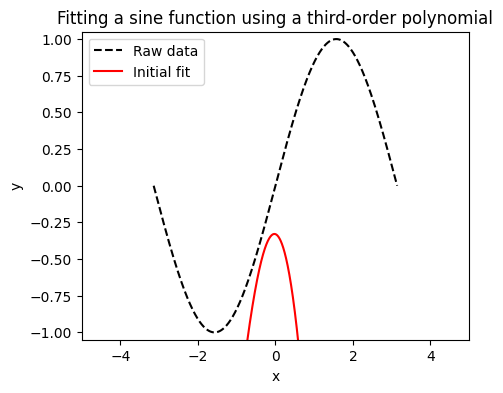

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.plot(x, y, color='k', ls='--', label='Raw data')
ax.plot(x, y_pred_initial, color='r', label='Initial fit')

ax.set_xlim(-5, 5)
ax.set_ylim(-1.05, 1.05)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Fitting a sine function using a third-order polynomial')

ax.legend()
plt.show()

Now that we have our 'network' with 'weights' and our data, let's get our training parameters:

In [6]:
learning_rate = 1e-6
epochs = 2000

Now in the following we train our 'network'. We:
1. Compute the forward pass (get prediction)
2. Compute the loss (MSE loss in this case)
3. Perform backpropagation using this simple loss function and network
4. Update weights using learning rate

In [7]:
since = time.time()
print('training started...')
for t in range(epochs):
    # forward pass: compute predicted y
    # y = a + b x + c x^2 + d x^3
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # compute and print loss
    loss = np.square(y_pred - y).sum()
    if t % 100 == 99:
        print(f'Epoch: {t:4}, Loss: {loss:0.3f}')

    # backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # update weights
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

print('training finished!')
print(f'training took: {time.time() - since: 0.3f} seconds.')

y_pred_final = func(a, b, c, d, x)
print(f'Final function: y = {a} + {b} x + {c} x^2 + {d} x^3')

training started...
Epoch:   99, Loss: 567.370
Epoch:  199, Loss: 378.175
Epoch:  299, Loss: 253.070
Epoch:  399, Loss: 170.339
Epoch:  499, Loss: 115.631
Epoch:  599, Loss: 79.453
Epoch:  699, Loss: 55.529
Epoch:  799, Loss: 39.708
Epoch:  899, Loss: 29.245
Epoch:  999, Loss: 22.327
Epoch: 1099, Loss: 17.751
Epoch: 1199, Loss: 14.725
Epoch: 1299, Loss: 12.724
Epoch: 1399, Loss: 11.401
Epoch: 1499, Loss: 10.526
Epoch: 1599, Loss: 9.947
Epoch: 1699, Loss: 9.565
Epoch: 1799, Loss: 9.311
Epoch: 1899, Loss: 9.144
Epoch: 1999, Loss: 9.033
training finished!
training took:  0.333 seconds.
Final function: y = -0.0008279973504683186 + 0.8424669897231627 x + 0.0001428433208911632 x^2 + -0.09130005769928147 x^3


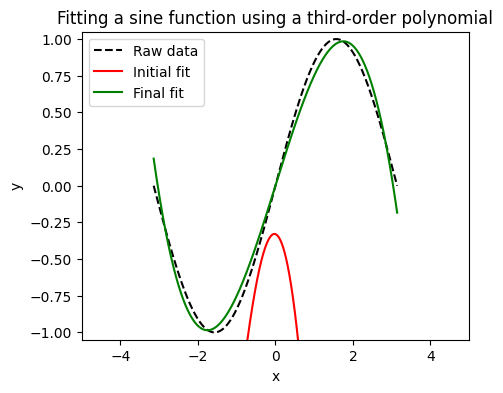

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.plot(x, y, color='k', ls='--', label='Raw data')
ax.plot(x, y_pred_initial, color='r', label='Initial fit')
ax.plot(x, y_pred_final, color='g', label='Final fit')

ax.set_xlim(-5, 5)
ax.set_ylim(-1.05, 1.05)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Fitting a sine function using a third-order polynomial')

ax.legend()
plt.show()

### Torch

For modern deep neural networks, GPUs often provide speedups of 50x or greater, so unfortunately numpy won’t be enough for modern deep learning. Like the numpy example above we need to manually implement the forward and backward passes through the network. First, let's set our device to run on the GPU if available, otherwise run on the CPU:

In [9]:
# set up device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if device.type == 'cuda':
    print(f'using: {torch.cuda.get_device_name(0) if device.type == "cuda" else f"CPU with cores available: {os.cpu_count()}"}')

using: NVIDIA GeForce MX350


Now, we will perform all the above steps, instead using torch tensors. Note that when we want to use torch tensors for other operations (eg: plotting) we need to put them onto the CPU and then convert to numpy:

In [10]:
# create random input and output data
x = torch.linspace(-math.pi, math.pi, 2000, dtype=torch.float).to(device)
y = torch.sin(x)

# create function
func = lambda a, b, c, d, x: a + b * x + c * x**2 + d * x**3

# randomly initialize weights
a = torch.randn((), dtype=torch.float).to(device)
b = torch.randn((), dtype=torch.float).to(device)
c = torch.randn((), dtype=torch.float).to(device)
d = torch.randn((), dtype=torch.float).to(device)

y_pred_initial = func(a, b, c, d, x)

print(f'Initial function: y = {a} + {b} x + {c} x^2 + {d} x^3')

# set parameters
learning_rate = 1e-6
epochs = 2000

since = time.time()
print('training started...')
for t in range(epochs):
    # forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(f'Epoch: {t:4}, Loss: {loss:0.3f}')

    # backprop to compute gradients of a, b, c, d with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

print('training finished!')
print(f'training took: {time.time() - since: 0.3f} seconds.')

y_pred_final = func(a, b, c, d, x)
print(f'Final function: y = {a} + {b} x + {c} x^2 + {d} x^3')

Initial function: y = -1.3788280487060547 + 1.1146165132522583 x + -0.6790425777435303 x^2 + -0.8263880610466003 x^3
training started...
Epoch:   99, Loss: 1045.135
Epoch:  199, Loss: 738.079
Epoch:  299, Loss: 522.177
Epoch:  399, Loss: 370.310
Epoch:  499, Loss: 263.446
Epoch:  599, Loss: 188.224
Epoch:  699, Loss: 135.258
Epoch:  799, Loss: 97.952
Epoch:  899, Loss: 71.668
Epoch:  999, Loss: 53.144
Epoch: 1099, Loss: 40.086
Epoch: 1199, Loss: 30.880
Epoch: 1299, Loss: 24.386
Epoch: 1399, Loss: 19.806
Epoch: 1499, Loss: 16.575
Epoch: 1599, Loss: 14.294
Epoch: 1699, Loss: 12.685
Epoch: 1799, Loss: 11.549
Epoch: 1899, Loss: 10.747
Epoch: 1999, Loss: 10.180
training finished!
training took:  0.908 seconds.
Final function: y = -0.03858577832579613 + 0.8624140620231628 x + 0.006656689569354057 x^2 + -0.09413734823465347 x^3


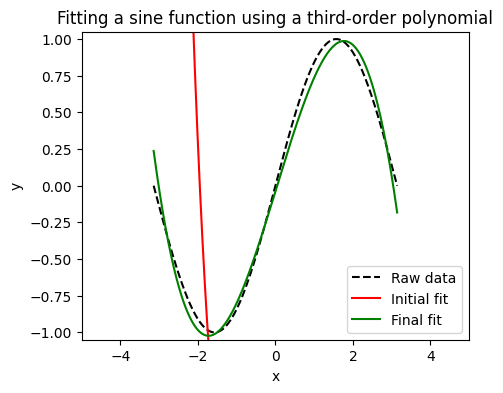

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.plot(x.cpu().numpy(), y.cpu().numpy(), color='k', ls='--', label='Raw data')
ax.plot(x.cpu().numpy(), y_pred_initial.cpu().numpy(), color='r', label='Initial fit')
ax.plot(x.cpu().numpy(), y_pred_final.cpu().numpy(), color='g', label='Final fit')

ax.set_xlim(-5, 5)
ax.set_ylim(-1.05, 1.05)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Fitting a sine function using a third-order polynomial')

ax.legend()
plt.show()

## Autograd

In the above examples, we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very hairy for large complex networks. Thankfully, we can use [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) to automate the computation of backward passes in neural networks.

Here we use PyTorch Tensors and autograd to implement our fitting sine wave with third order polynomial example; now we no longer need to manually implement the backward pass through the network. Note that we now also have to detach the tensor from autograd in order to use it for functionality such as plotting:

In [12]:
# by default, requires_grad=False, which indicates that we do not need to
# compute gradients with respect to these Tensors during the backward pass
x = torch.linspace(-math.pi, math.pi, 2000, dtype=torch.float)
y = torch.sin(x)

# create function
func = lambda a, b, c, d, x: a + b * x + c * x**2 + d * x**3

# setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass
a = torch.randn((), dtype=torch.float, requires_grad=True)
b = torch.randn((), dtype=torch.float, requires_grad=True)
c = torch.randn((), dtype=torch.float, requires_grad=True)
d = torch.randn((), dtype=torch.float, requires_grad=True)

y_pred_initial = func(a, b, c, d, x)

print(f'Initial function: y = {a} + {b} x + {c} x^2 + {d} x^3')

# set parameters
learning_rate = 1e-6
epochs = 2000

since = time.time()
print('training started...')
for t in range(2000):
    # forward pass: compute predicted y using operations on Tensors
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # compute and print loss using operations on Tensors
    # now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(f'Epoch: {t:4}, Loss: {loss.item():0.3f}')

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        a -= learning_rate * a.grad
        b -= learning_rate * b.grad
        c -= learning_rate * c.grad
        d -= learning_rate * d.grad

        # Manually zero the gradients after updating weights
        a.grad = None
        b.grad = None
        c.grad = None
        d.grad = None

print('training finished!')
print(f'training took: {time.time() - since: 0.3f} seconds.')

y_pred_final = func(a, b, c, d, x)
print(f'Final function: y = {a} + {b} x + {c} x^2 + {d} x^3')

Initial function: y = 0.7647252082824707 + 0.12343931943178177 x + -0.49517133831977844 x^2 + -0.22632072865962982 x^3
training started...
Epoch:   99, Loss: 782.412
Epoch:  199, Loss: 540.334
Epoch:  299, Loss: 374.420
Epoch:  399, Loss: 260.576
Epoch:  499, Loss: 182.372
Epoch:  599, Loss: 128.590
Epoch:  699, Loss: 91.562
Epoch:  799, Loss: 66.041
Epoch:  899, Loss: 48.432
Epoch:  999, Loss: 36.269
Epoch: 1099, Loss: 27.859
Epoch: 1199, Loss: 22.037
Epoch: 1299, Loss: 18.004
Epoch: 1399, Loss: 15.207
Epoch: 1499, Loss: 13.266
Epoch: 1599, Loss: 11.916
Epoch: 1699, Loss: 10.978
Epoch: 1799, Loss: 10.325
Epoch: 1899, Loss: 9.870
Epoch: 1999, Loss: 9.553
training finished!
training took:  0.571 seconds.
Final function: y = 0.026000013574957848 + 0.8455490469932556 x + -0.004485436715185642 x^2 + -0.09173844754695892 x^3


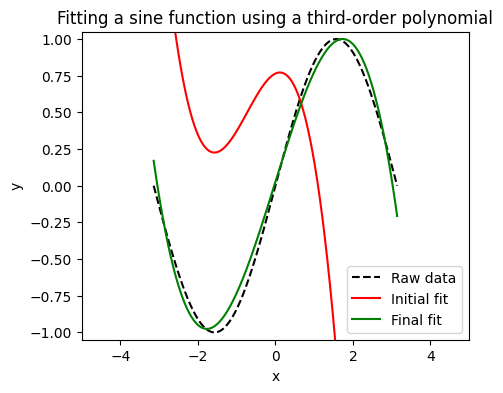

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.plot(x.cpu().numpy(), y.cpu().numpy(), color='k', ls='--', label='Raw data')
ax.plot(x.cpu().numpy(), y_pred_initial.cpu().detach().numpy(), color='r', label='Initial fit')
ax.plot(x.cpu().numpy(), y_pred_final.cpu().detach().numpy(), color='g', label='Final fit')

ax.set_xlim(-5, 5)
ax.set_ylim(-1.05, 1.05)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Fitting a sine function using a third-order polynomial')

ax.legend()
plt.show()

Note that it is possible to make your own Autograd functionality in order to compute the forward/backward passes. This is not necessary, but may be useful for specific use-cases.

## Neural Networks

### nn

When building neural networks we frequently think of arranging the computation into layers, some of which have learnable parameters which will be optimized during learning. The `nn` package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

In this example we use the nn package to implement our polynomial model network. Lets create our data as before:

In [14]:
# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000).to(device)
y = torch.sin(x)

Now, lets look at the data more closely:

In [15]:
x.shape, x

(torch.Size([2000]),
 tensor([-3.1416, -3.1384, -3.1353,  ...,  3.1353,  3.1384,  3.1416],
        device='cuda:0'))

We add on another dimensionby using the `unsqueeze()` method:

In [16]:
x.unsqueeze(-1).shape, x.unsqueeze(-1)

(torch.Size([2000, 1]),
 tensor([[-3.1416],
         [-3.1384],
         [-3.1353],
         ...,
         [ 3.1353],
         [ 3.1384],
         [ 3.1416]], device='cuda:0'))

Using this, we can expand our data to include values for all of $x, x^2, x^3$. This allows us to use a Linear (Dense) layer with 3 inputs (and thus our 3 weights $a, b, c$, and a bias - equivalent to $d$) to create our function:

In [17]:
p = torch.tensor([1, 2, 3]).to(device)
xx = x.unsqueeze(-1).pow(p)
xx.shape

torch.Size([2000, 3])

Let's create a Sequential model consisting of a Linear and a Flatten layer:

In [18]:
# nn.Sequential is a Module which contains other Modules
# The Linear Module computes output from input using a linear function
# The Flatten layer flatens the output of the linear layer to a 1D tensor
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)
model.to(device)

Sequential(
  (0): Linear(in_features=3, out_features=1, bias=True)
  (1): Flatten(start_dim=0, end_dim=1)
)

In [19]:
y_pred_initial = model(xx)
y_pred_initial.shape, y_pred_initial

(torch.Size([2000]),
 tensor([-16.5045, -16.4582, -16.4119,  ...,  15.4086,  15.4543,  15.5002],
        device='cuda:0', grad_fn=<ViewBackward0>))

The nn package also contains definitions of popular loss functions. Lets define this and some hyperparameters here:

In [20]:
# Mean Squared Error (MSE) as our loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

# hyperparameters
learning_rate = 1e-6
epochs = 2000

In [21]:
since = time.time()
print('training started...')
for t in range(epochs):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(xx)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(f'Epoch: {t:4}, Loss: {loss.item():0.3f}')

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

print('training finished!')
print(f'training took: {time.time() - since: 0.3f} seconds.')

y_pred_final = model(xx)
# You can access the first layer of `model` like accessing the first item of a list
linear_layer = model[0]
print(f'Final function: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

training started...
Epoch:   99, Loss: 364.337
Epoch:  199, Loss: 247.756
Epoch:  299, Loss: 169.540
Epoch:  399, Loss: 117.024
Epoch:  499, Loss: 81.733
Epoch:  599, Loss: 57.999
Epoch:  699, Loss: 42.022
Epoch:  799, Loss: 31.257
Epoch:  899, Loss: 23.998
Epoch:  999, Loss: 19.098
Epoch: 1099, Loss: 15.786
Epoch: 1199, Loss: 13.547
Epoch: 1299, Loss: 12.030
Epoch: 1399, Loss: 11.003
Epoch: 1499, Loss: 10.305
Epoch: 1599, Loss: 9.832
Epoch: 1699, Loss: 9.510
Epoch: 1799, Loss: 9.290
Epoch: 1899, Loss: 9.141
Epoch: 1999, Loss: 9.039
training finished!
training took:  0.924 seconds.
Final function: y = -0.011415041983127594 + 0.84676593542099 x + 0.001969285309314728 x^2 + -0.09191154688596725 x^3


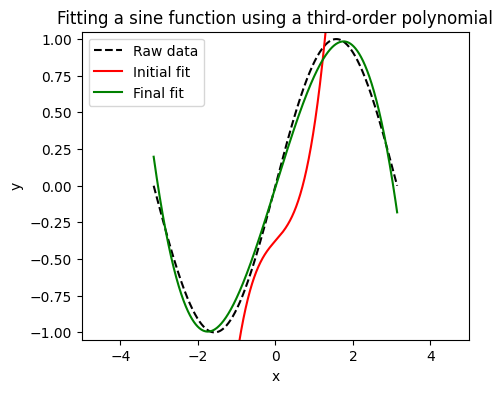

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.plot(x.cpu().numpy(), y.cpu().numpy(), color='k', ls='--', label='Raw data')
ax.plot(x.cpu().numpy(), y_pred_initial.cpu().detach().numpy(), color='r', label='Initial fit')
ax.plot(x.cpu().numpy(), y_pred_final.cpu().detach().numpy(), color='g', label='Final fit')

ax.set_xlim(-5, 5)
ax.set_ylim(-1.05, 1.05)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Fitting a sine function using a third-order polynomial')

ax.legend()
plt.show()

### optim

Up to this point we have updated the weights of our models by manually mutating the Tensors holding learnable parameters with ``torch.no_grad()``. This is not a huge burden for simple optimization algorithms like stochastic gradient descent, but in practice we often train neural networks using more sophisticated optimizers. The ``optim`` package in PyTorch abstracts the idea of an optimization algorithm and provides implementations of commonly used optimization algorithms.

In this example we will use the ``nn`` package to define our model as before, but we will optimize the model using the ``RMSprop`` algorithm provided by the ``optim`` package:

In [23]:
# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000).to(device)
y = torch.sin(x)

# Prepare the input tensor (x, x^2, x^3).
p = torch.tensor([1, 2, 3]).to(device)
xx = x.unsqueeze(-1).pow(p)

# Use the nn package to define our model and loss function.
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)
model.to(device)

y_pred_initial = model(xx)

# Mean Squared Error (MSE) as our loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

# hyperparameters
learning_rate = 1e-3
epochs = 2000

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

since = time.time()
print('training started...')
for t in range(epochs):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(xx)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(f'Epoch: {t:4}, Loss: {loss.item():0.3f}')

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

print('training finished!')
print(f'training took: {time.time() - since: 0.3f} seconds.')

y_pred_final = model(xx)
# You can access the first layer of `model` like accessing the first item of a list
linear_layer = model[0]
print(f'Final function: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

training started...
Epoch:   99, Loss: 22718.211
Epoch:  199, Loss: 9753.551
Epoch:  299, Loss: 3704.763
Epoch:  399, Loss: 1276.934
Epoch:  499, Loss: 625.465
Epoch:  599, Loss: 505.913
Epoch:  699, Loss: 443.359
Epoch:  799, Loss: 374.814
Epoch:  899, Loss: 299.553
Epoch:  999, Loss: 224.105
Epoch: 1099, Loss: 156.431
Epoch: 1199, Loss: 101.467
Epoch: 1299, Loss: 60.678
Epoch: 1399, Loss: 33.438
Epoch: 1499, Loss: 17.850
Epoch: 1599, Loss: 10.988
Epoch: 1699, Loss: 9.123
Epoch: 1799, Loss: 8.839
Epoch: 1899, Loss: 8.872
Epoch: 1999, Loss: 9.011
training finished!
training took:  1.483 seconds.
Final function: y = -0.0009808667236939073 + 0.856188178062439 x + -0.0009817535756155849 x^2 + -0.09400776028633118 x^3


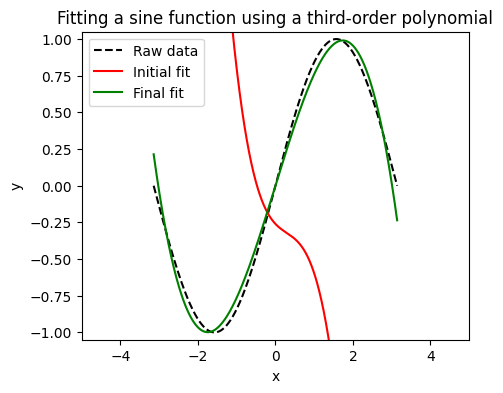

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.plot(x.cpu().numpy(), y.cpu().numpy(), color='k', ls='--', label='Raw data')
ax.plot(x.cpu().numpy(), y_pred_initial.cpu().detach().numpy(), color='r', label='Initial fit')
ax.plot(x.cpu().numpy(), y_pred_final.cpu().detach().numpy(), color='g', label='Final fit')

ax.set_xlim(-5, 5)
ax.set_ylim(-1.05, 1.05)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Fitting a sine function using a third-order polynomial')

ax.legend()
plt.show()

## Custom modules

Sometimes you will want to specify models that are more complex than a sequence of existing Modules; for these cases you can define your own Modules by subclassing ``nn.Module`` and defining a forward which receives input Tensors and produces output Tensors using other modules or other autograd operations on Tensors.

In this example we implement our third order polynomial as a custom ``Module`` subclass, directly writing the function rather than using a Linear layer:

In [25]:
class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'

Then input and model as before:

In [26]:
# Create Tensors to hold input and outputs.
x = torch.linspace(-math.pi, math.pi, 2000).to(device)
y = torch.sin(x)

# Construct our model by instantiating the class defined above
model = Polynomial3()
model.to(device)

y_pred_initial = model(x)
y_pred_initial.shape, y_pred_initial

(torch.Size([2000]),
 tensor([ -0.3546,  -0.3676,  -0.3807,  ..., -18.1057, -18.1557, -18.2057],
        device='cuda:0', grad_fn=<AddBackward0>))

We can access a weight (parameter) like:

In [27]:
model.a.item(), model.a

(-0.033451635390520096,
 Parameter containing:
 tensor(-0.0335, device='cuda:0', requires_grad=True))

Now training, using SGD instead:

In [28]:
# hyperparameters
learning_rate = 1e-6
epochs = 2000

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters (defined 
# with torch.nn.Parameter) which are members of the model.
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

since = time.time()
print('training started...')
for t in range(epochs):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(f'Epoch: {t:4}, Loss: {loss.item():0.3f}')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print('training finished!')
print(f'training took: {time.time() - since: 0.3f} seconds.')

y_pred_final = model(x)
print(f'Final function: {model.string()}')

training started...
Epoch:   99, Loss: 20.251
Epoch:  199, Loss: 16.830
Epoch:  299, Loss: 14.437
Epoch:  399, Loss: 12.761
Epoch:  499, Loss: 11.586
Epoch:  599, Loss: 10.762
Epoch:  699, Loss: 10.184
Epoch:  799, Loss: 9.778
Epoch:  899, Loss: 9.493
Epoch:  999, Loss: 9.292
Epoch: 1099, Loss: 9.152
Epoch: 1199, Loss: 9.053
Epoch: 1299, Loss: 8.983
Epoch: 1399, Loss: 8.934
Epoch: 1499, Loss: 8.899
Epoch: 1599, Loss: 8.875
Epoch: 1699, Loss: 8.858
Epoch: 1799, Loss: 8.846
Epoch: 1899, Loss: 8.838
Epoch: 1999, Loss: 8.832
training finished!
training took:  1.611 seconds.
Final function: y = 0.003920001443475485 + 0.8559654951095581 x + -0.0006762652192264795 x^2 + -0.09322009980678558 x^3


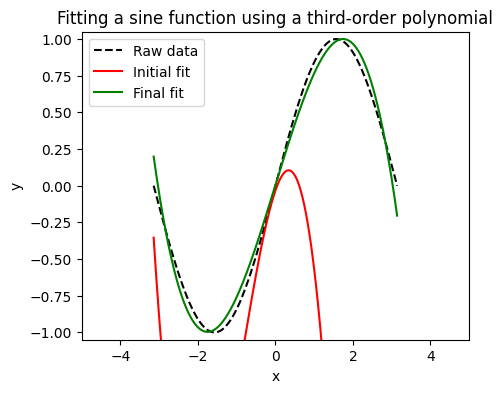

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

ax.plot(x.cpu().numpy(), y.cpu().numpy(), color='k', ls='--', label='Raw data')
ax.plot(x.cpu().numpy(), y_pred_initial.cpu().detach().numpy(), color='r', label='Initial fit')
ax.plot(x.cpu().numpy(), y_pred_final.cpu().detach().numpy(), color='g', label='Final fit')

ax.set_xlim(-5, 5)
ax.set_ylim(-1.05, 1.05)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Fitting a sine function using a third-order polynomial')

ax.legend()
plt.show()